# 1. Observations on 1 pixel kernel

# 2. BMENet with maxpool

In [ ]:
import os, sys
print(os.getcwd())
sys.path.append("./../DLStudio-2.5.1")

from DLStudio import *

In [2]:
class BMEnetModifiedForMaxpool(BMEnet):
    def __init__(self, dl_studio, skip_connections=True, depth=8, use_maxpool=False):
        super().__init__(dl_studio, skip_connections, depth, use_maxpool)

    class SkipBlock(nn.Module):
            """
            Class Path:   DLStudio  ->  BMEnet  ->  SkipBlock
            """            
        def __init__(self, in_ch, out_ch, downsample=False, use_maxpool=False, skip_connections=True):
            super().__init__()
            self.downsample = downsample
            self.use_maxpool = use_maxpool
            self.skip_connections = skip_connections
            self.in_ch = in_ch
            self.out_ch = out_ch
            self.convo1 = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
            self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(in_ch)
            self.bn2 = nn.BatchNorm2d(out_ch)
            self.in2out = nn.Conv2d(in_ch, out_ch, 1)

            if downsample:
                if use_maxpool:
                    self.downsampler = nn.MaxPool2d(2, 2)  # Single max pooling layer
                else:
                    self.downsampler1 = nn.Conv2d(in_ch, in_ch, 1, stride=2)
                    self.downsampler2 = nn.Conv2d(out_ch, out_ch, 1, stride=2)

                    
            def forward(self, x):
                identity = x                                     
                out = self.convo1(x)                              
                out = self.bn1(out)                              
                out = nn.functional.relu(out)
                out = self.convo2(out)                              
                out = self.bn2(out)                              
                out = nn.functional.relu(out)
                if self.downsample:
                    identity = self.downsampler1(identity)
                    out = self.downsampler2(out)
                if self.skip_connections:
                    if (self.in_ch == self.out_ch) and (self.downsample is False):
                        out = out + identity
                    elif (self.in_ch != self.out_ch) and (self.downsample is False):
                        identity = self.in2out( identity )     
                        out = out + identity
                    elif (self.in_ch != self.out_ch) and (self.downsample is True):
                        out = out + torch.cat((identity, identity), dim=1)
                return out

    



current_dir = /home/chen4126/ece60146/HW6


### 2.1 Train loss curve

### 2.2 Confusion Matrix

# 3. BMENet with stride

Files already downloaded and verified
Files already downloaded and verified


The number of learnable parameters in the model: 30195330


Starting training loop...



[epoch:1/6  iter=1000  elapsed_time=   52 secs]   Ground Truth:            dog       deer       ship        cat      plane      truck        cat      horse       bird       deer       ship        cat       deer       frog       ship       bird        car        cat       bird        dog        car       deer      horse      truck       frog      truck       deer       ship       ship        cat      plane      truck
[epoch:1/6  iter=1000  elapsed_time=   52 secs]   Predicted Labels:        dog       deer       ship        cat      plane      truck        dog      horse       frog       deer       ship      horse       deer       frog        car       bird       ship       frog      horse        dog      truck       bird       frog      truck       frog      truck       frog      truck       ship       bird      plane     

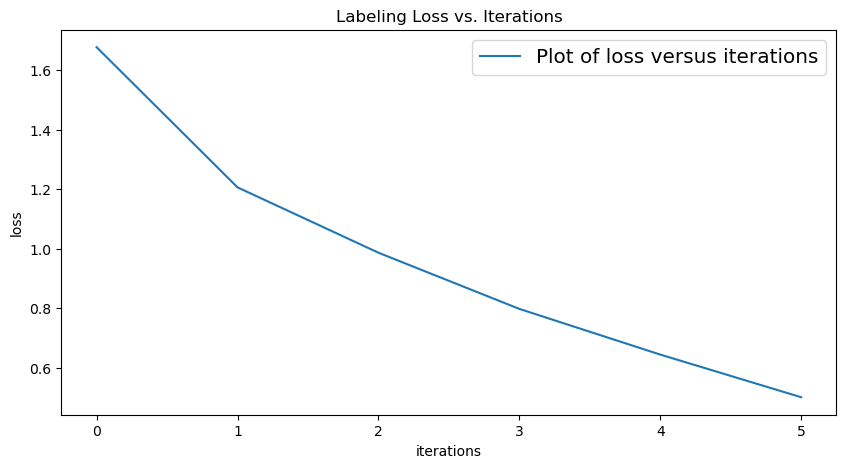

IndexError: index 16 is out of bounds for dimension 0 with size 16

In [9]:
dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/CIFAR-10/",
                dataroot = "./../data/CIFAR-10/",
                image_size = [32,32],
                path_saved_model = "./saved_model",
                momentum = 0.9,
                learning_rate = 1e-4,
                epochs = 6,
                batch_size = 32,
                classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck'),
                use_gpu = True,
            )

bme_net = dls.BMEnet(dls, skip_connections=True, depth=8)         ## if you want to use skips

bme_net.load_cifar_10_dataset()

## display network properties
number_of_learnable_params = sum(p.numel() for p in bme_net.parameters() if p.requires_grad)
print("\n\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)

## training and testing
bme_net.run_code_for_training(bme_net, display_images=False)
bme_net.run_code_for_testing(bme_net, display_images=False)


### 3.1 Train loss curve

### 3.2 Confusion Matrix

# 4. Table1: Overall accuracy of 2 models table

# 5. Table2: Per class accuracy of 2 models (10x2 table)

# 6. Observations of Maxpool vs Stride

# 7. Skip Connections with MSCOCO

### 7.1 5x3 images

### 7.2 train loss curve

### 7.3 conf matrix 5x5

### 7.4 overall accuracy

### 7.5 per class accuracy 5x1 table

### 7.6 observations